# 拉普拉斯机制
- 对每个结果加入独立的拉普拉斯噪声来满足差分隐私
- 噪声参数$ \lambda $取决于当我们修改一个人的数据时，查询结果总共会改变多少
    - 一组查询总共的“最大改变”被称为他们的敏感度
    - 取$ \lambda = 敏感度/\varepsilon $即能满足$\varepsilon$-差分隐私


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math
plt.style.use('seaborn-whitegrid')

In [3]:
ATTNAME = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status',
           'occupation', 'relationship', 'race', 'sex', 
            'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'incom']


In [4]:
def readdata():
    df=pd.read_csv('adult.data.txt',names = ['age', 'workclass', 'fnlwgt','education','education_num','marital_status','occupation','relationship','race','sex','capital_gain','capital_loss','hours_per_week','native_country','incom'],header=None)
    return df

In [5]:
def generate_laplace(df):
    oldestidx, twentysixidx, youngestidx = -1, -1, -1
    oldest, youngest = -float('inf'), float('inf')
    for idx, record in df.iterrows():
        if record['age'] == -1:
            continue
        if record['age'] >= oldest:
            if record['age'] != oldest or random.random() >= 0.5:
                oldestidx, oldest = idx, record['age']
        if record['age'] <= youngest:
            if record['age'] != youngest or random.random() >= 0.5:
                youngestidx, youngest = idx, record['age']
        if record['age'] == 26 and (twentysixidx != -1 or random.random() >= 0.5):
            twentysixidx = idx
    version1=df.drop(index=oldestidx)
    version2=df.drop(index=twentysixidx)
    version3=df.drop(index=youngestidx)
    return version1, version2, version3

In [6]:
class LaplaceMechanism():
    def __init__(self, records):
        self.records = records
        self.s = self.__calculate_sensitivity()
        print("sensitivity="+str(self.s))
        
    def __calculate_sensitivity(self):
        # 计算敏感度
        num, oldage = 0, -float('inf')
        oldage=self.records['age'].max()
        num=self.records['age'][self.records['age']>25].count()
        return oldage / num
    
    def __laplacian_noise(self, e):
        #根据敏感度和epsilon 计算噪声
        return np.random.laplace(self.s/e)
    
    def query_with_dp(self, e = 1, querynum=1000, above_age = 25):
        # 返回添加拉普拉斯噪声后的结果
        agegt25=self.records['age'][self.records['age']>above_age]
        avgage = sum(agegt25) / len(agegt25)
        res = []
        for _ in range(querynum):
            # 添加拉普拉斯噪声
            res.append(round(avgage + self.__laplacian_noise(e), 2))
        return res
    
    def calc_groundtruth(self, above_age = 25):
        agesum=self.records['age'][self.records['age']>above_age].sum()
        num=self.records['age'][self.records['age']>above_age].count()
        return round(agesum / num, 2)
    
    def calc_distortion(self, queryres):
        # 计算失真度——均方根误差
        groundtruth = self.calc_groundtruth()
        print("groundtruth=",groundtruth)
        rmse = (sum((res - groundtruth)**2 for res in queryres) / len(queryres))**(1/2)
        print("distortion=",rmse)
        return rmse
    
def prove_indistinguishable(queryres1, queryres2, bucketnum = 20):
    # 对拉普拉斯机制的不可分证明
    # 返回[queryres1/queryres2，queryres2/queryres1],和e^epsilon作比较
    maxval = max(max(queryres1), max(queryres2))
    minval = min(min(queryres1), min(queryres2))
    count1 = [0 for _ in range(bucketnum)]
    count2 = [0 for _ in range(bucketnum)]
    
    for val1, val2 in zip(queryres1, queryres2):
        count1[math.floor((val1-minval+1)/((maxval-minval+1)/bucketnum))-1] += 1
        count2[math.floor((val2-minval+1)/((maxval-minval+1)/bucketnum))-1] += 1
        
    prob1 = list(map(lambda x: x/len(queryres1), count1))
    prob2 = list(map(lambda  x: x/len(queryres2), count2))

    res1overres2 = sum(p1 / p2 for p1, p2 in zip(prob1, prob2) if p2 != 0) / bucketnum
    res2overres1 = sum(p2 / p1 for p1, p2 in zip(prob1, prob2) if p1 != 0) / bucketnum
    return res1overres2, res2overres1

In [7]:
eps = [0.5, 1]
recordsv0 = readdata()
recordsv1, recordsv2, recordsv3 = generate_laplace(recordsv0)
res1000 = {e:[] for e in eps}
rmse = {e: 0 for e in eps}
printsent = ['original data', 'data removed a record with the oldest age', 
                'data removed any record with age 26', 'data removed any record with the youghest age']
i = 0
for records in (recordsv0, recordsv1, recordsv2, recordsv3):
    print('############ Processing for {} ############'.format(printsent[i]))
    i += 1
    LampMec = LaplaceMechanism(records)
    for e in eps:
        print('query 1000 results with epsilon = {}'.format(e))
        res1000[e].append(LampMec.query_with_dp(e, querynum=1000))
        rmse[e] = LampMec.calc_distortion(LampMec.query_with_dp(e, querynum=4000))
    print('\n')
    
for e in eps:
    print('############ Prove the {}-indistinguishable'.format(e))
    for i in range(1, 4):
        tmpresij, tmpresji = prove_indistinguishable(res1000[e][0], res1000[e][i])
        print('** {} ** OVER ** {} **:'.format(printsent[0], printsent[i]))
        print(tmpresij)
        print('** {} ** OVER ** {} **:'.format(printsent[i], printsent[0]))
        print(tmpresji)
        print('exp^e = {}'.format(math.exp(e)))
        print('\n')
    
print('############ Measure the distortion (RMSE) ############')
for e in eps:
    print('RMSE for e = {}: {}'.format(e, rmse[e]))
print('Distortion of e=1 is smaller than e=0.5 ?: ', True if rmse[1] <= rmse[0.5] else False)
del recordsv0
del recordsv1
del recordsv2
del recordsv3


############ Processing for original data ############
sensitivity=0.0034416826003824093
query 1000 results with epsilon = 0.5
groundtruth= 42.78
distortion= 1.4202154502046525
query 1000 results with epsilon = 1
groundtruth= 42.78
distortion= 1.3836472816437027


############ Processing for data removed a record with the oldest age ############
sensitivity=0.0034418142185169607
query 1000 results with epsilon = 0.5
groundtruth= 42.78
distortion= 1.4120335335961403
query 1000 results with epsilon = 1
groundtruth= 42.78
distortion= 1.4260965517804185


############ Processing for data removed any record with age 26 ############
sensitivity=0.0034418142185169607
query 1000 results with epsilon = 0.5
groundtruth= 42.78
distortion= 1.4253599720772308
query 1000 results with epsilon = 1
groundtruth= 42.78
distortion= 1.4150100971371213


############ Processing for data removed any record with the youghest age ############
sensitivity=0.0034416826003824093
query 1000 results with epsilon = 

In [8]:
def cac_avg_age(type = 1,dellist = []):
    df = readdata()
    if type==1:
        newage = df['age'].apply(lambda x: 12.5 if x =="0-25" else (
            37.5 if x == "25-50" else (
            62.5 if x == "50-75" else (
            87.5 if x == "75-100" else(
            25 if x == "0-50" else 75 )))))
    else: 
        newage = df['age']
    
    if len(dellist)!=0:
        for i in dellist:
            newage=newage.drop(i)
    return newage.sum()/newage.shape[0]    

真实平均年龄：
 38.58164675532078
请输入您想要查询的范围(默认大于25岁)
25
sensitivity=0.0034416826003824093


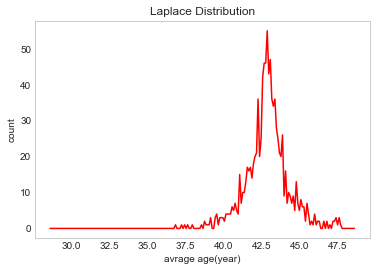

差分隐私查询1000次的均值为：
 42.73467999999997
请输入要删除的索引:
0
删除索引为0,年龄为39
sensitivity=0.0034418142185169607


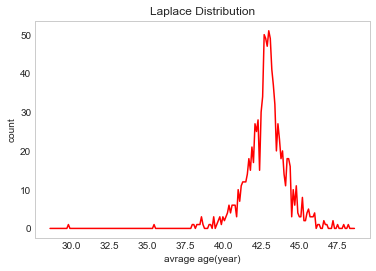

执行以上操作后,差分隐私后平均年龄：
 42.709830000000004
根据前后数值差分攻击得到删除掉的年龄为：
 851.8506799989846


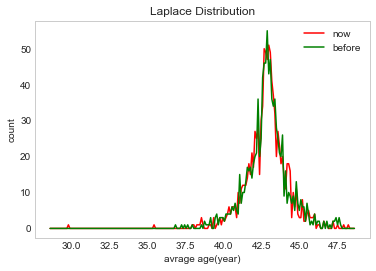

In [9]:
#初始化参数
k = 10
real_avg_age = 0
dellist = []
mistake = {'real':[],'k_anonymize':[],'DP':[]}
xlist = []
ylist = []

avg_age = cac_avg_age(type=2, dellist=dellist)
print("真实平均年龄：\n",avg_age)
real_avg_age = avg_age

records = readdata()
aa = int(input("请输入您想要查询的范围(默认大于25岁)\n"))
LapMe = LaplaceMechanism(records)
#添加拉普拉斯噪声后的结果
res1 = LapMe.query_with_dp(e=0.5, querynum=1000,above_age = aa)

#画图
delta = 0.1
bumket = [0 for i in range(0,int(20/delta))]
for i in res1:
    bumket[int((i-real_avg_age-10)/delta)] +=1

# 显示年龄的分布
x_lable = np.linspace(round(real_avg_age-10,1),round(real_avg_age+10,1),200)
xlist.append(x_lable)
ylist.append(bumket)
fig, ax = plt.subplots()
ax.plot(x_lable,bumket,color = 'r' )
ax.set(xlabel='avrage age(year)', ylabel='count', title='Laplace Distribution')
ax.grid()
plt.show()

avg_age_DP = sum(res1)/len(res1)
mistake['DP'].append(avg_age_DP)   
print("差分隐私查询1000次的均值为：\n",avg_age_DP)

delp = int(input("请输入要删除的索引:\n"))  
dellist.append(delp)
if len(dellist)!=0:
    for i in dellist:
        print("删除索引为{},年龄为{}".format(i,records['age'][i]))
        records = records.drop(i)

LapMe = LaplaceMechanism(records)
res1 = LapMe.query_with_dp(0.5, 1000,above_age = aa)
#画图
bumket = [0 for i in range(0,int(20/delta))]
for i in res1:
    bumket[int((i-real_avg_age-10)/delta)] +=1
x_lable = np.linspace(round(real_avg_age-10,1),round(real_avg_age+10,1),200)
xlist.append(x_lable)
ylist.append(bumket)
fig, ax = plt.subplots()
ax.plot(x_lable,bumket,color = 'r' )
ax.set(xlabel='avrage age(year)', ylabel='count', title='Laplace Distribution')
ax.grid()
plt.show()
avg_age_DP = sum(res1)/len(res1)

mistake['DP'].append(avg_age_DP)


#差分攻击        
print("执行以上操作后,差分隐私后平均年龄：\n",avg_age_DP)
age_predict = mistake['DP'][0]*(len(records)+len(dellist)) - avg_age_DP*len(records)
print("根据前后数值差分攻击得到删除掉的年龄为：\n",age_predict)
del mistake['DP'][1]
if len(dellist)>0:
    del dellist[0]
fig, ax = plt.subplots()
line1, = ax.plot(x_lable,bumket,color = 'r' )
line2, = ax.plot(xlist[0],ylist[0],color = 'g' )
plt.legend((line1,line2),('now','before'))
ax.set(xlabel='avrage age(year)', ylabel='count', title='Laplace Distribution')
ax.grid()
plt.show()